## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import time
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

## Utils

In [3]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
def set_device():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  if torch.cuda.is_available:
    print('PyTorch can use GPUs!')
  else:
    print('PyTorch cannot use GPUs.')

  return device

device = set_device()

PyTorch can use GPUs!


### Set Debug

In [5]:
# DEBUG = False
DEBUG = True

# Define Dataset

In [6]:
def build_windows(data, window_width=1000, stride=None, normalize=False):
    if stride is None:
        stride = 1

    # Create view of sliding windows using NumPy's striding tricks
    shape = ((data.shape[0] - window_width) // stride + 1, window_width, data.shape[1])
    strides = (data.strides[0] * stride, data.strides[0], data.strides[1])

    windows = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

    # Normalize channels independently if requested
    if normalize:
        # Reshape to flatten all windows for channel-wise normalization
        reshaped_data = windows.reshape(-1, data.shape[1])

        # Normalize each channel independently using z-score (mean=0, std=1)
        normalized_data = (reshaped_data - reshaped_data.mean(axis=0)) / reshaped_data.std(axis=0)

        # Reshape back to original windows shape
        windows = normalized_data.reshape(shape)

    return torch.from_numpy(windows).float()

In [7]:
class MyoCombinedDataset(Dataset):
  def __init__(self, root_dir, num_files, split, split_ratio=0.8, num_samples_per_window=1000, stride=1, transform=None):
    myo_datas = []
    leap_datas = []

    for i in range(num_files):
      myo_file = f"s{i+1}_bleData.csv"
      # myo_file = f"myo8_rect_s{i+1}_bleData.csv"
      # myo_file = f"myo4_env_s{i+1}_bleData.csv"
      myo_file_path = os.path.join(root_dir, myo_file)
      myo_df = pd.read_csv(myo_file_path)
      myo_data = np.asarray(myo_df.iloc[:, 2:])
      myo_datas.append(myo_data)

      # leap_file = f"myo4_env_s{i+1}_leapData.csv"
      # leap_file = f"myo8_rect_s{i+1}_leapData.csv"
      leap_file = f"s{i+1}_leapData.csv"
      leap_file_path = os.path.join(root_dir, leap_file)
      leap_df = pd.read_csv(leap_file_path)
      leap_data = np.asarray(leap_df.iloc[:, 2:])
      leap_datas.append(leap_data)


    myo_data = [build_windows(arr, window_width=1000, stride=stride, normalize=True) for arr in myo_datas]
    self.myo_data = torch.cat(myo_data, dim=0)

    leap_data = [build_windows(arr, window_width=1000, stride=stride) for arr in leap_datas]
    self.leap_data = torch.cat(leap_data, dim=0)

    # TODO: Potentially shuffle data before train-test split? Get rid of
    #   closing finger tracking script artifacts?
    # Combine and shuffle data to remove potential sequential artifacts
    shuffle_indices = torch.randperm(self.myo_data.shape[0])
    self.myo_data = self.myo_data[shuffle_indices]
    self.leap_data = self.leap_data[shuffle_indices]

    assert(self.myo_data.shape[0] == self.leap_data.shape[0])

    self.split = split
    self.num_samples_per_window = num_samples_per_window
    self.transform = transform

    if split == 'train':
      self.myo_data = self.myo_data[:int(split_ratio*len(self.myo_data))]
      self.leap_data = self.leap_data[:int(split_ratio*len(self.leap_data))]
    elif split == 'test':
      self.myo_data = self.myo_data[int(split_ratio*len(self.myo_data)):]
      self.leap_data = self.leap_data[int(split_ratio*len(self.leap_data)):]

    print("Dataset created")
    print(self.myo_data.shape)
    print(self.leap_data.shape)

  def __len__(self):
    return self.myo_data.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    myo_sample = self.myo_data[idx, :].type(torch.float32).unsqueeze(0)
    leap_sample = self.leap_data[idx,:].type(torch.float32).unsqueeze(0)

    if myo_sample.shape[2] == 4:
      padding = torch.zeros((myo_sample.shape[0], myo_sample.shape[1], 4))
      myo_sample = torch.cat((myo_sample, padding), dim=2)

    sample = {'myo': myo_sample, 'leap': leap_sample}

    if self.transform:
      sample = self.transform(sample)

    return sample

  def get_min_max(self, column_index):
    # print(f"min: {self.leap_data[:, :, column_index].min()}, max: {self.leap_data[:, :, column_index].max()}")
    return [self.leap_data[:, :, column_index].min(), self.leap_data[:, :, column_index].max()]

  def get_min_max_leap(self, columns):
    min_max = {}
    for column in columns:
      min_max[column] = self.get_min_max(column)
    return min_max


# Test Dataset Works

In [8]:
DEBUG=True
if DEBUG:
  # root_dir = "/content/drive/MyDrive/2 ECEM202A Embedded System/Data/myo4_env_clean"
  root_dir = "/content/drive/MyDrive/2 ECEM202A Embedded System/Data/myo8_env_clean"
  myo_dataset = MyoCombinedDataset(
    root_dir=root_dir,
    num_files=1,
    split="train",
  )

  print(myo_dataset[1])

  sample = myo_dataset[1]
  print(sample['myo'].shape)
  print(sample['leap'].shape)


  m = myo_dataset.get_min_max_leap([0,1,2,3])
  print(m)

Dataset created
torch.Size([14238, 1000, 8])
torch.Size([14238, 1000, 16])
{'myo': tensor([[[-0.2752, -0.0160, -0.5209,  ..., -0.0633, -0.4149,  0.9154],
         [-0.2937, -0.1053, -0.5541,  ..., -0.1450, -0.3721,  0.4427],
         [-0.3123, -0.1948, -0.5873,  ..., -0.2267, -0.3293, -0.0300],
         ...,
         [-0.8262,  0.0794, -0.1778,  ..., -0.4630,  0.5009,  0.4742],
         [-0.7799,  0.2582, -0.1447,  ..., -0.5299,  0.4581,  0.4742],
         [-0.5349, -0.6001,  0.3777,  ..., -0.8746,  0.6978, -0.9966]]]), 'leap': tensor([[[-41.8680,  41.8680,  39.0640,  ...,  17.7900,  70.0980,  96.5080],
         [-42.1080,  42.1080,  39.9220,  ...,  17.5350,  68.4630,  94.5830],
         [-41.8030,  41.8030,  41.1440,  ...,  17.4150,  65.5260,  91.6400],
         ...,
         [-24.2990,  24.2990,  16.9550,  ...,  22.2700,  -2.5390,  11.9350],
         [-24.1010,  24.1010,  16.9300,  ...,  22.1430,  -2.4340,  11.6750],
         [-23.9240,  23.9240,  16.9070,  ...,  22.0320,  -2.3430,  

## Plot Samples of Dataset

In [9]:
def plot_sample(sample, sample_num):
  fig = plt.figure()
  fig.set_figwidth(24)
  fig.set_figheight(6)
  ax = plt.subplot(1, 2, 1)
  plt.tight_layout()
  ax.set_title(f"Myo Sample {sample_num}")
  ax.plot(sample['myo'].numpy()[0], label=[f"Myo {i}" for i in range(len(sample['myo'].numpy()[0][0]))])
  ax.legend()

  feature_names = ["tm_aa", "tm_flex", "mcp_aa", "mcp_flex"]
  for i in range(4):
    feature_names += ["mcp_aa", "mcp_flex", "pip"]
  ax2 = plt.subplot(1, 2, 2)
  plt.tight_layout()
  ax2.set_title(f"Leap Sample {sample_num}")
  ax2.plot(sample['leap'].numpy()[0], label=feature_names)
  ax2.legend()


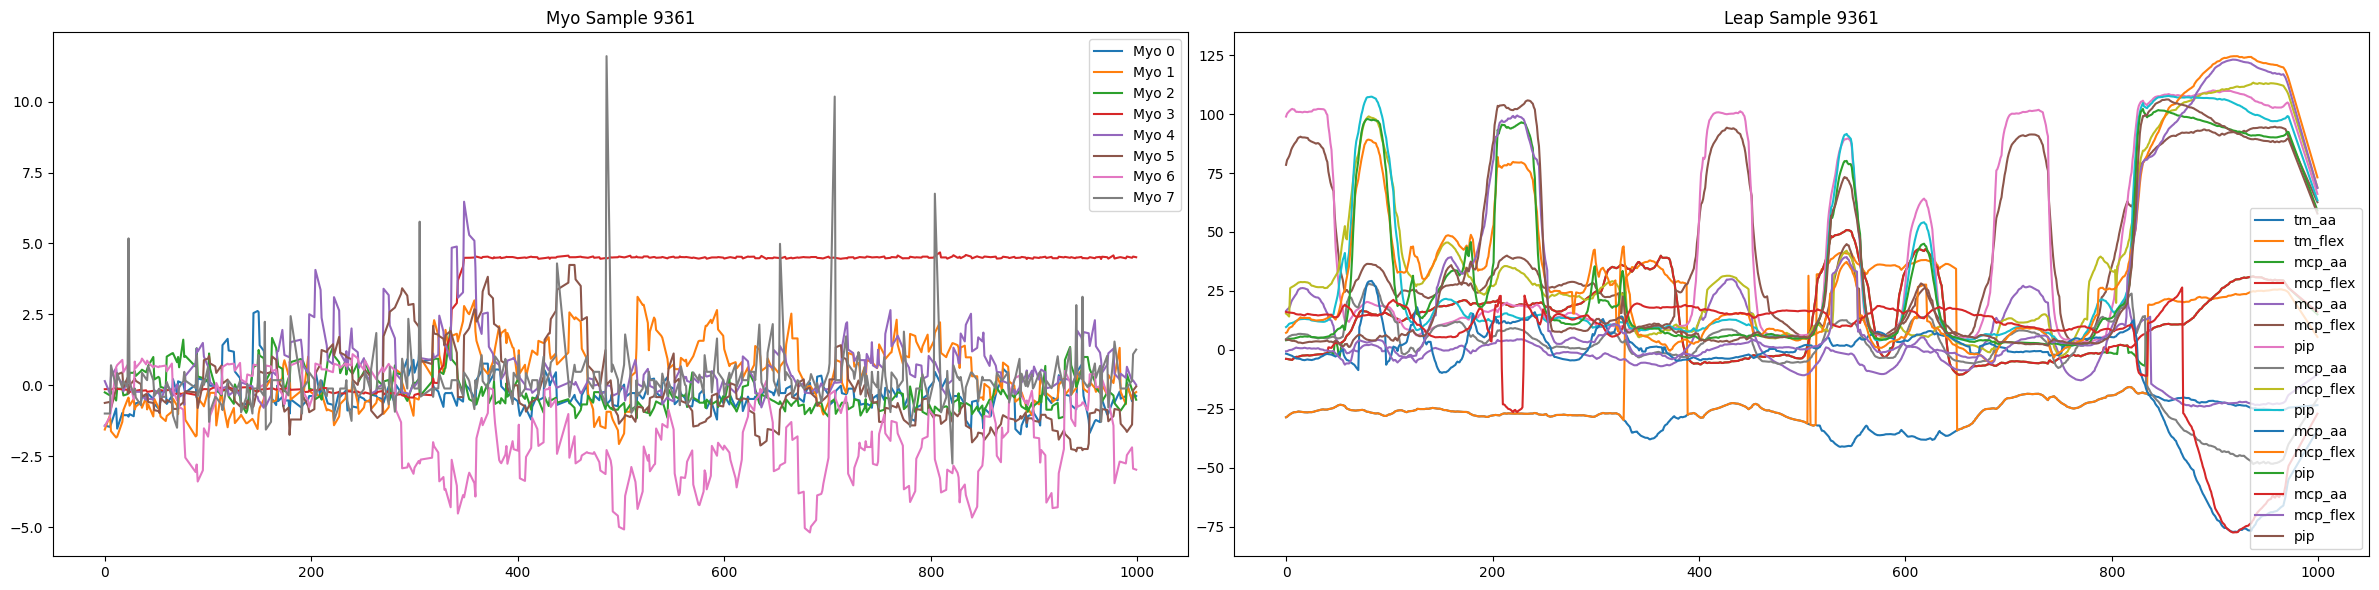

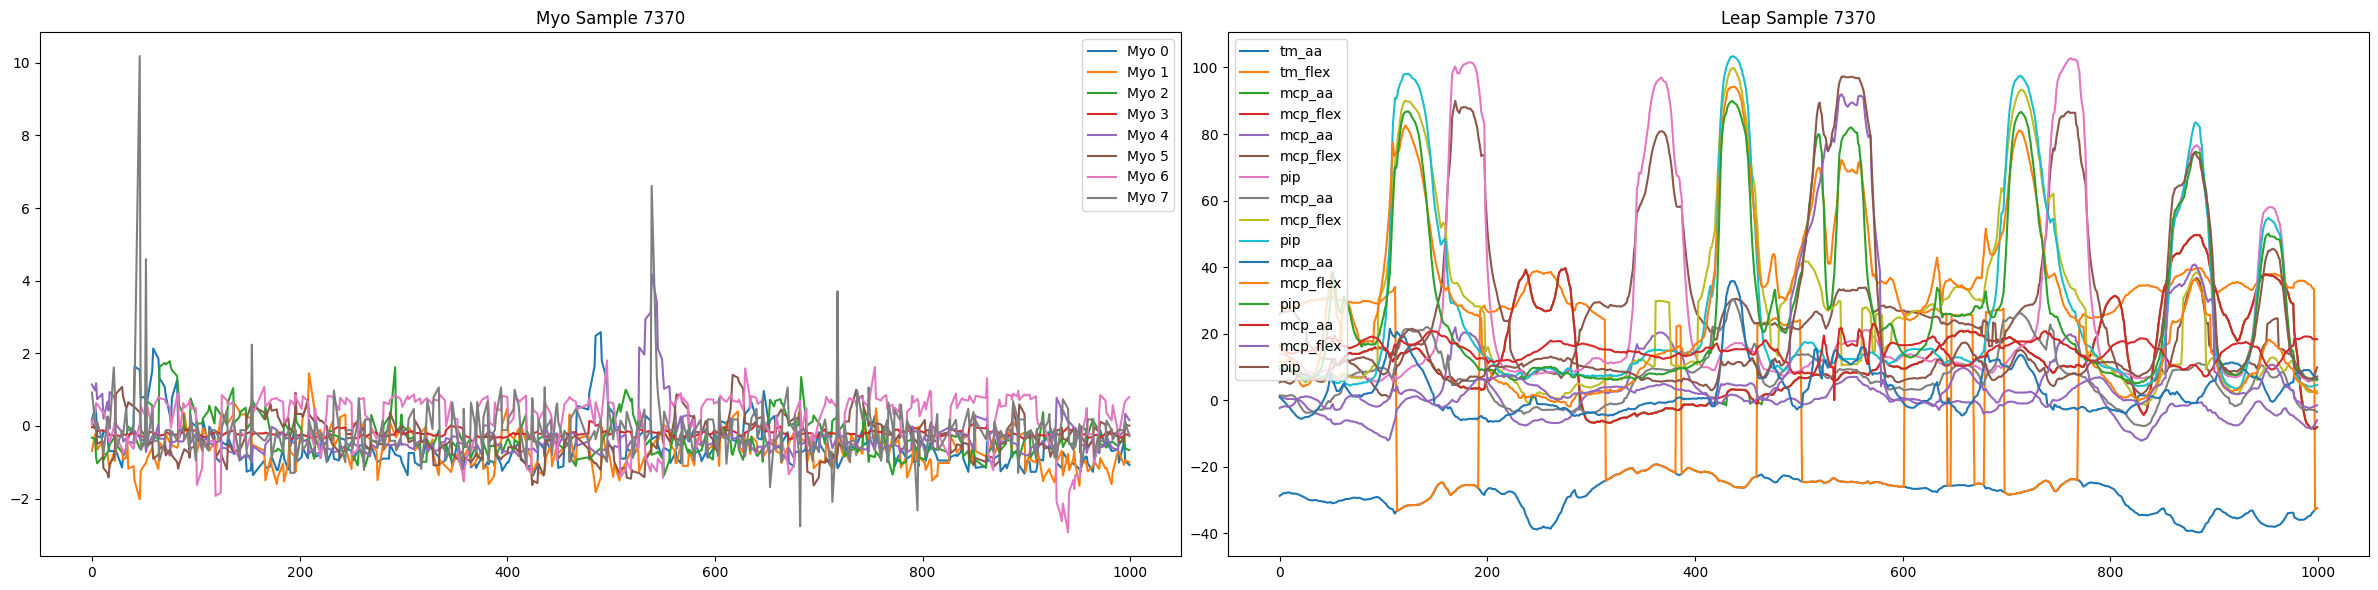

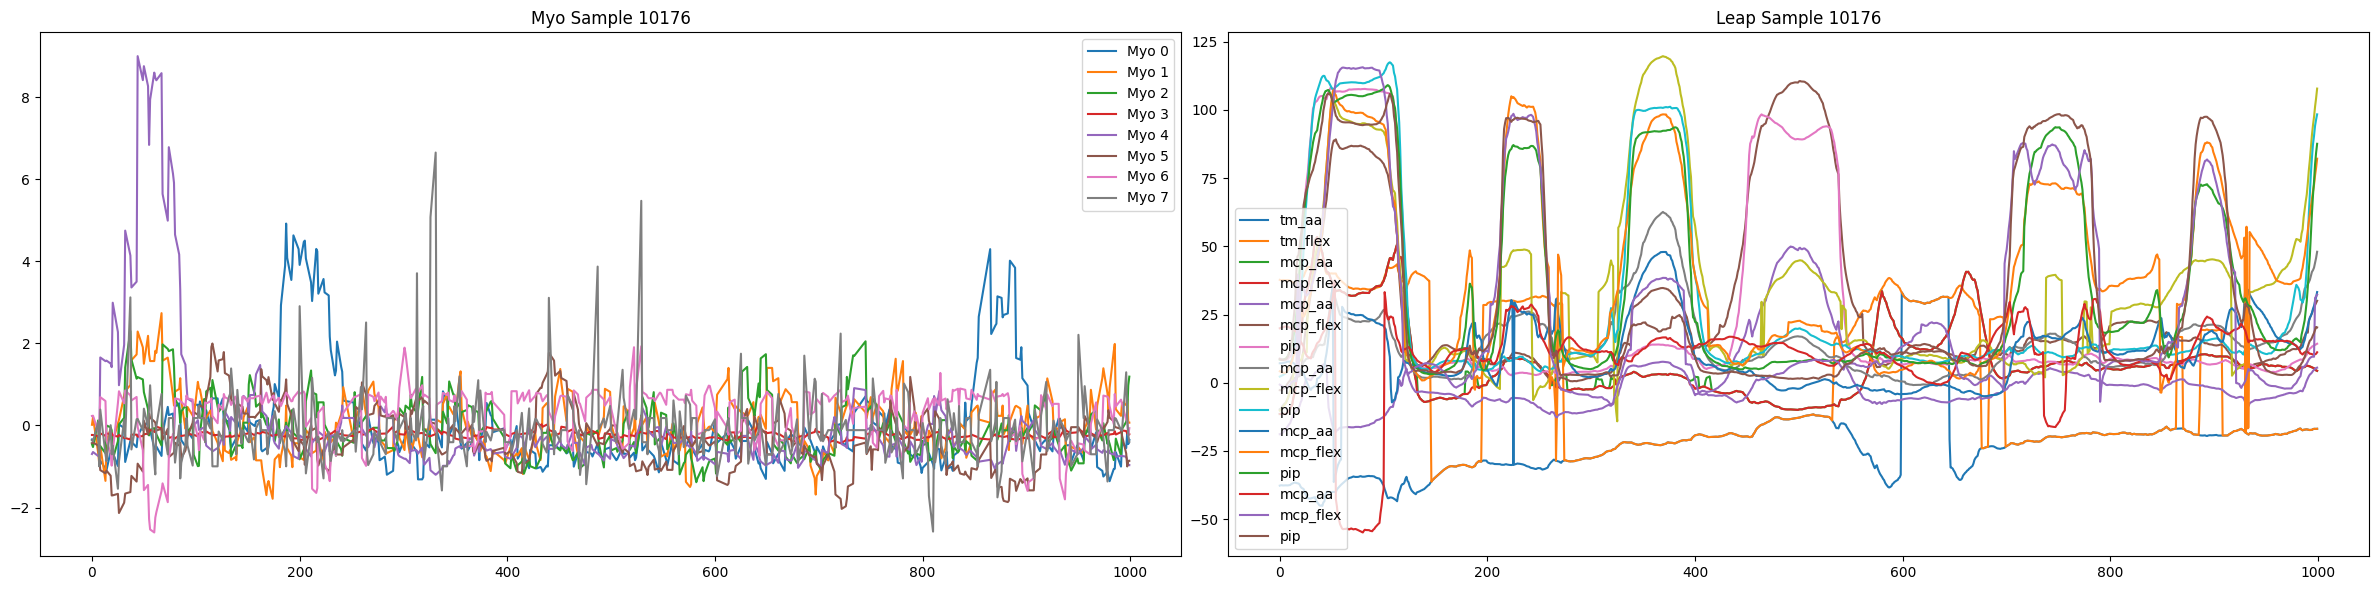

In [10]:
# Plot 3 Random Samples of our dataset
if DEBUG:
  sample_nums = [random.randint(0,len(myo_dataset)) for _ in range(3)]

  for j, sample_num in enumerate(sample_nums):
    sample = myo_dataset[sample_num]
    # print(f"myo shape: {sample['myo'].shape}")
    # # print(f"Sample {j+1} of {len(sample_nums)}")
    # for i in range(16):
    #   m = np.min(sample['leap'].numpy()[0, :, i])
    #   ma = np.max(sample['leap'].numpy()[0, :, i])
    #   print(f"min: {m}, max:{ma}")
    #   print(f"  {i} max: {sample['leap'].numpy()[0,:,i].max()}, min: {sample['leap'].numpy()[0,:,i].min()}")
    s = sample['leap'].numpy()[0]
    # print(f"{s}")
    plot_sample(sample, sample_num)
  plt.show()

In [11]:
if DEBUG:
  dataloader = DataLoader(myo_dataset, batch_size=4,
                          shuffle=True, num_workers=0)

# Define NeuroPose Model

In [12]:
class PrintLayer(nn.Module):
    def __init__(self, prefix=None):
        super(PrintLayer, self).__init__()
        self.prefix = prefix

    def forward(self, x):
        # Do your print / debug stuff here

        if not self.prefix:
          print(f"Layer Shape: {x.shape}")
        else:
          # print(f"{self.prefix}: {x.shape}")
          # Print the first 10 inputs along dimension 2
          print(f"{self.prefix}: {x[0,0,0:10, :]}")
        return x

In [13]:
class NeuroPoseEncoder(nn.Module):
  def __init__(self):
    super(NeuroPoseEncoder, self).__init__()

    in_channels = [1, 32, 128]
    out_channels = [32, 128, 256]
    maxPool_filters = [[5,2], [4,2], [2,2]]

    layers = []
    for i in range(3):
      layers += [
        nn.Conv2d(
          in_channels=in_channels[i],
          out_channels=out_channels[i],
          kernel_size=[3,2],
          padding=[1,1],
        ),
        # PrintLayer(f"encoder conv {i} output"),
        nn.BatchNorm2d(out_channels[i]),
        nn.ReLU(),
        nn.Dropout(0.05),
        nn.MaxPool2d(kernel_size=maxPool_filters[i]),
        # PrintLayer(f"encoder maxpool {i} output"),
      ]
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    x = self.layers(x)
    return x


encoder = NeuroPoseEncoder()
print(encoder)

NeuroPoseEncoder(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): MaxPool2d(kernel_size=[5, 2], stride=[5, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 128, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): MaxPool2d(kernel_size=[4, 2], stride=[4, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.05, inplace=False)
    (14): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
)


In [14]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    out += identity
    out = self.relu(out)

    return out


residual_block = ResidualBlock(in_channels=256, out_channels=256)
print(residual_block)

ResidualBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [15]:
class NeuroPoseDecoder(nn.Module):
  def __init__(self):
    super(NeuroPoseDecoder, self).__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(
          in_channels=256,
          out_channels=128,
          kernel_size=[3,2],
          padding="same",
        ),
        # PrintLayer(f"decoder conv 1"),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=(5,4)),
        # PrintLayer(f"decoder upsample 1"),
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(
          in_channels=128,
          out_channels=32,
          kernel_size=[3,2],
          padding="same",
        ),
        # PrintLayer(f"decoder conv 2"),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Upsample(scale_factor=(4,2)),
        # PrintLayer(f"decoder upsample 2"),
    )
    self.block_3 = nn.Sequential(
        nn.Conv2d(
          in_channels=32,
          out_channels=1,
          kernel_size=[3,2],
          padding="same",
        ),
        # PrintLayer(f"decoder conv 3"),
        nn.BatchNorm2d(1),
        # No activation function from last CONV layer to keep negative outputs
        nn.Upsample(scale_factor=(2,2)),
        # PrintLayer(f"decoder upsample 3"),
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    return x


decoder = NeuroPoseDecoder()
print(decoder)

NeuroPoseDecoder(
  (block_1): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=(5.0, 4.0), mode='nearest')
  )
  (block_2): Sequential(
    (0): Conv2d(128, 32, kernel_size=(3, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=(4.0, 2.0), mode='nearest')
  )
  (block_3): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Upsample(scale_factor=(2.0, 2.0), mode='nearest')
  )
)


In [16]:
class BoundedReLU(nn.Module):
    def __init__(self, lower_bound=0, upper_bound=1):
        super().__init__()
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def forward(self, x):
        return torch.clamp(torch.nn.functional.relu(x), self.lower_bound, self.upper_bound)

class NeuroPoseOutputNorm(nn.Module):
  def __init__(self, leap_thumb_min_max):
    super(NeuroPoseOutputNorm, self).__init__()
    self.leap_thumb_min_max = leap_thumb_min_max

    self.mcp_aa_inds = [4, 7, 10, 13]
    self.mcp_flex_inds = [5, 8, 11, 14]
    self.pip_inds = [6, 9, 12, 15]

    self.mcp_aa_bound = [-15, 15]
    self.pip_bound = [0, 110]

    self.bRelu = BoundedReLU()
    self.k_bRelu = BoundedReLU(0, 0.5)

  def forward(self, x):
    # Avoid in-place modifications
    x_out = x.clone()

    # # Min-max normalization for thumb angles
    for i, min_max in self.leap_thumb_min_max.items():
      x_out[:,:,:,i] = ((F.sigmoid(x[:,:,:,i]) - 0) * (min_max[1] - min_max[0])) / (1) + min_max[0]

    # Safe normalization with small epsilon to prevent division by zero
    eps = 1e-8

    # MCP Abduction-Adduction Normalization
    normed_mcp_aa = self.bRelu(x_out[:,:,:,self.mcp_aa_inds] / (self.mcp_aa_bound[1] + eps)) * self.mcp_aa_bound[1]

    # PIP Normalization
    normed_pip = self.bRelu(x_out[:,:,:,self.pip_inds] / (self.pip_bound[1] + eps)) * self.pip_bound[1]

    # Safe k calculation with additional safeguards
    k = x_out[:,:,:,self.mcp_flex_inds] / (normed_pip + eps)
    k = self.k_bRelu(k)
    normed_mcp_flex = k * normed_pip

    # Update output tensor
    x_out[:,:,:,self.mcp_aa_inds] = normed_mcp_aa
    x_out[:,:,:,self.mcp_flex_inds] = normed_mcp_flex
    x_out[:,:,:,self.pip_inds] = normed_pip

    return x_out

In [17]:
class NeuroPoseAutoencoder(nn.Module):
  def __init__(self, leap_thumb_min_max, use_norm=True):
    super(NeuroPoseAutoencoder, self).__init__()
    self.use_norm = use_norm

    self.encoder = NeuroPoseEncoder()

    res_layers = []
    for i in range(5):
      res_layers += [ResidualBlock(in_channels=256, out_channels=256)]
    self.residual_blocks = nn.Sequential(*res_layers)

    self.decoder = NeuroPoseDecoder()

    if self.use_norm:
      self.norm_layer = NeuroPoseOutputNorm(leap_thumb_min_max)

  def forward(self, x):
    x = self.encoder(x)
    x = self.residual_blocks(x)
    x = self.decoder(x)

    if self.use_norm:
      x = self.norm_layer(x)
    return x

autoencoder = NeuroPoseAutoencoder({})
print(autoencoder)

NeuroPoseAutoencoder(
  (encoder): NeuroPoseEncoder(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.05, inplace=False)
      (4): MaxPool2d(kernel_size=[5, 2], stride=[5, 2], padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(32, 128, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Dropout(p=0.05, inplace=False)
      (9): MaxPool2d(kernel_size=[4, 2], stride=[4, 2], padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): Dropout(p=0.05, inplace=False)
      (14): MaxPool2d(kernel_size=[2,

# NeuroPose Custom Loss Function

The loss function MSE loss in prediction of the joint angles for each finger individually as well as a smoothness loss term that enforces a constant velocity constraint.

In [18]:
class NeuroPoseLoss(nn.Module):
  def __init__(self):
    super(NeuroPoseLoss, self).__init__()
    self.prev_pred = None

  def forward(self, output, target):
    mcp_aa_inds = [4, 7, 10, 13]
    mcp_flex_inds = [5, 8, 11, 14]
    pip_inds = [6, 9, 12, 15]

    loss_mcp_aa = 0
    for i in mcp_aa_inds:
      loss_mcp_aa += torch.pow((output[:,:,:,i] - target[:,:,:,i]), 2)
    loss_mcp_aa = torch.mean(loss_mcp_aa)

    loss_mcp_fe = 0
    for i in mcp_flex_inds:
      loss_mcp_fe += torch.pow((output[:,:,:,i] - target[:,:,:,i]), 2)
    loss_mcp_fe = torch.mean(loss_mcp_fe)

    loss_pip_fe = 0
    for i in pip_inds:
      loss_pip_fe += torch.pow((output[:,:,:,i] - target[:,:,:,i]), 2)
    loss_pip_fe = torch.mean(loss_pip_fe)

    loss_thumb_tm_aa = torch.mean(torch.pow(output[:,:,:,0] - target[:,:,:,0], 2))
    loss_thumb_tm_fe = torch.mean(torch.pow(output[:,:,:,1] - target[:,:,:,1], 2))
    loss_thumb_mcp_aa = torch.mean(torch.pow(output[:,:,:,2] - target[:,:,:,2], 2))
    loss_thumb_mcp_fe = torch.mean(torch.pow(output[:,:,:,3] - target[:,:,:,3], 2))

    loss_thumb = (loss_thumb_mcp_aa + loss_thumb_mcp_fe + loss_thumb_tm_aa + loss_thumb_tm_fe)/4

    if self.prev_pred is None:
      loss_smoothness = 0
    else:
      loss_smoothness = torch.sum(torch.pow(output.grad - self.prev_pred.grad, 2))
      self.prev_pred = output

    loss = (loss_mcp_aa + loss_mcp_fe + loss_pip_fe + loss_thumb + loss_smoothness) / 5

    return loss

In [19]:
def calc_angle_err(logits, labels):
  batch_feature_errs = []
  for batch_idx in range(labels.shape[0]):
    angle_errs_per_batch = []
    for feature_idx in range(labels.shape[-1]):
      # Extract feature-specific outputs and targets
      feature_output = logits[batch_idx, :, :, feature_idx]
      feature_target = labels[batch_idx, :, :, feature_idx]

      # Calculate Angle Error in degrees
      angle_errs_per_batch.append(torch.mean(torch.abs(feature_output - feature_target)).item())
    batch_feature_errs.append(angle_errs_per_batch)

  return batch_feature_errs

In [20]:
def generate_err_boxplot(err_array, title="Finger Joint Error Distribution"):
  """
  Generate a boxplot of error in degrees for each finger joint feature

  Parameters:
  - err_array: NumPy array of error in degrees values with shape [num_batches, num_features]
  """

  num_fingers = 4
  feature_names = ["tm_aa", "tm_flex", "mcp_aa", "mcp_flex"]
  for i in range(num_fingers):
    feature_names += ["mcp_aa", "mcp_flex", "pip"]

  finger_names = ["Thumb", "Index", "Middle", "Ring", "Pinky"]

  fig, ax = plt.subplots(layout='constrained', figsize=(7, 4))
  bplot = plt.boxplot(err_array,
                     showfliers=False,
                     patch_artist=True,
                     whis=1.9,
                     boxprops=dict(facecolor="skyblue"),
                     medianprops=dict(color="skyblue"))


  ax.set_title(title)
  ax.set_ylabel('Error in Degrees')

  ax.set_ylim(bottom=0)

  sec = ax.secondary_xaxis(location=0)
  sec.set_xticks([2.5, 6, 9, 12, 15], labels=[f"\n\n\n\n\n{n}" for n in finger_names])
  sec.tick_params('x', length=0, width=0)

  sec2 = ax.secondary_xaxis(location=0)
  sec2.set_xticks([0, 4.5, 7.5, 10.5, 13.5, 16.5], labels=[])
  sec2.tick_params('x', length=40, width=1)

  ax.set_xticklabels(feature_names, rotation=65)
  plt.show()

In [21]:
class Trainer(object):
  """Training Helper Class"""
  def __init__(self, cfg, model, optimizer, criterion, save_path, device, save_best_worst=False, scheduler=None):
    self.cfg = cfg # config for training : see class Config
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.save_path = save_path
    self.device = device # device name
    self.scheduler = scheduler
    self.save_best_worst = save_best_worst

    self.training_loss_list = []
    self.validation_loss_list = []

    self.best = {
        "input": None,
        "logits": None,
        "labels": None,
        "loss": 1e8
    }

    self.worst = self.best.copy()
    self.worst["loss"] = -1

  def train(self, train_loader, val_loader, plot=True):
    # Place model on device
    model = self.model.to(self.device)

    global_step = 0 # global iteration steps regardless of epochs

    start_time = time.time()

    self.training_loss_list = []
    self.validation_loss_list = []

    try:
      for epoch in range(self.cfg["num_epochs"]):
          step_loss = []
          total_step_loss = 0.0
          model.train()  # Set model to training mode

          loss_sum = 0. # the sum of iteration losses to get average loss in every epoch
          time_sum = 0.0

          # Use tqdm to display a progress bar during training
          with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{self.cfg["num_epochs"]}') as pbar:
            for i, loader in enumerate(train_loader):
              start_time = time.time()

              # Move inputs and labels to device
              inputs = loader['myo'].to(self.device)
              labels = loader['leap'].to(self.device)

              # Zero out gradients
              self.optimizer.zero_grad()

              # Compute the logits and loss
              logits = model(inputs)
              loss = self.criterion(logits, labels)

              # Backpropagate the loss
              loss.backward()

              # Update the weights and LR scheduler
              self.optimizer.step()
              total_step_loss += loss.item()
              # step_loss.append(loss.item())

              # Update the progress bar
              pbar.update(1)
              pbar.set_postfix(loss=loss.item())

              # if i == 0:
              #   break

            if self.scheduler is not None:
              self.scheduler.step()

          # Evaluate the model on the validation set, plotting angle error box
          #   plot every 5 epochs
          if (epoch+1) %5 != 0:
          # if (epoch+0) %5 != 0:
            avg_loss = self.evaluate(val_loader)
          else:
            avg_loss = self.evaluate(val_loader, True)
          model.train()

          self.training_loss_list.append(total_step_loss / len(train_loader))
          self.validation_loss_list.append(avg_loss)

          print(f"Validation loss: {avg_loss}")
          if avg_loss < self.best["loss"]:
            print("saved new best model")
            self.best["input"] = inputs
            self.best["logits"] = logits
            self.best["labels"] = labels
            self.save(0)

    except KeyboardInterrupt:
      print("\nTraining Interrupted")
      _ = self.evaluate(val_loader, True)

    if plot:
      self.plot_loss()

    return self.training_loss_list, self.validation_loss_list

  def evaluate(self, val_loader, plot_boxplot=False):
    model = self.model.eval()  # Set model to evaluation mode
    angle_errs = []

    with torch.no_grad():
      total_loss = 0.0
      num_correct = 0
      num_samples = 0

      for i, (loader) in enumerate(val_loader):
        # Move inputs and labels to device
        inputs = loader['myo'].to(self.device)
        labels = loader['leap'].to(self.device)

        # Compute the logits and loss
        logits = model(inputs)
        loss = self.criterion(logits, labels)
        total_loss += loss.item()

        if plot_boxplot:
          angle_errs.extend(calc_angle_err(logits, labels))

        if self.save_best_worst and (i == 0 or loss > self.worst["loss"]):
          self.worst["input"] = inputs
          self.worst["logits"] = logits
          self.worst["labels"] = labels
          self.worst["loss"] = loss

        if self.save_best_worst and (i == 0 or loss < self.best["loss"]):
          print("Saving best model_dict from validation")
          self.best["input"] = inputs
          self.best["logits"] = logits
          self.best["labels"] = labels
          self.best["loss"] = loss
          self.save(0)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(val_loader)

    if plot_boxplot:
      angle_errs = np.array(angle_errs)
      generate_err_boxplot(angle_errs)

    return avg_loss


  def plot_loss(self):
    """ Plot training and validation loss """
    plt.plot(self.training_loss_list, label="Training Loss")
    plt.plot(self.validation_loss_list, label="Eval Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

  def load(self, model_file, load_self=False):
    """ load saved model or pretrained transformer (a part of model) """
    if model_file:
      print('Loading the model from', model_file)
      if load_self:
        self.model.load_self(model_file + '.pt', map_location=self.device)
      else:
        self.model.load_state_dict(torch.load(model_file + '.pt', map_location=self.device))

  def save(self, i=0):
    """ save current model """
    if i != 0:
      torch.save(self.model.state_dict(), self.save_path + "_" + str(i) + '.pt')
    else:
      torch.save(self.model.state_dict(),  self.save_path + '.pt')


# Train Model

In [22]:
seed_everything(0)

# Initialize dataset
root_dir = "/content/drive/MyDrive/2 ECEM202A Embedded System/Data/myo8_env_clean"

num_files=10
train_data = MyoCombinedDataset(
  root_dir=root_dir,
  num_files=num_files,
  split="train",
  stride=1
)

thumb_idxs = [0,1,2,3]
leap_thumb_min_max = train_data.get_min_max_leap(thumb_idxs)
print(f"\nThumb Min Max: {leap_thumb_min_max}\n")

test_data = MyoCombinedDataset(
  root_dir=root_dir,
  num_files=num_files,
  split="test",
  stride=1
)

Dataset created
torch.Size([146381, 1000, 8])
torch.Size([146381, 1000, 16])

Thumb Min Max: {0: [tensor(-55.9820), tensor(53.1180)], 1: [tensor(-48.1660), tensor(55.9820)], 2: [tensor(-33.5360), tensor(54.6690)], 3: [tensor(-26.5100), tensor(54.6690)]}

Dataset created
torch.Size([36596, 1000, 8])
torch.Size([36596, 1000, 16])


In [25]:
# Initialize Neuropose Model
model = NeuroPoseAutoencoder(leap_thumb_min_max)

# Define the Optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,
    amsgrad=False
)


# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Set the Loss Function
# criterion = nn.MSELoss()
criterion = NeuroPoseLoss()

Epoch 1/25:   0%|          | 0/2288 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(
Epoch 1/25: 100%|██████████| 2288/2288 [01:07<00:00, 33.98it/s, loss=2.39e+3]


Validation loss: 2178.664885620971


Epoch 2/25: 100%|██████████| 2288/2288 [01:03<00:00, 36.07it/s, loss=2.06e+3]


Validation loss: 1979.7539354871203


Epoch 3/25: 100%|██████████| 2288/2288 [01:03<00:00, 36.13it/s, loss=2.08e+3]


Validation loss: 1812.8998214614976


Epoch 4/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.97it/s, loss=2.1e+3]


Validation loss: 1632.2298784589434


Epoch 5/25: 100%|██████████| 2288/2288 [01:03<00:00, 36.13it/s, loss=1.26e+3]


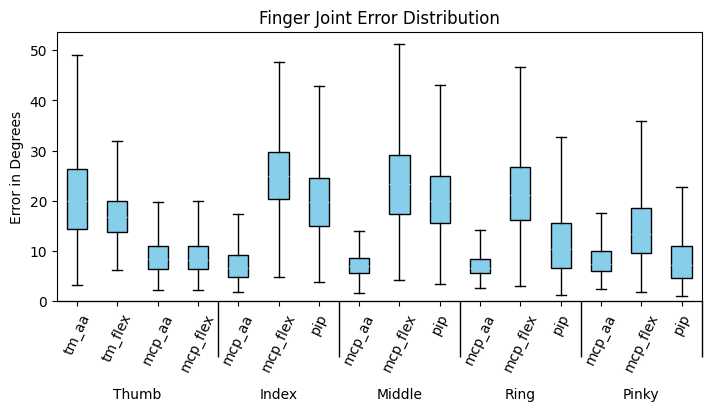

Validation loss: 1481.4100237226153


Epoch 6/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.97it/s, loss=2.17e+3]


Validation loss: 1410.9188185471755


Epoch 7/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.91it/s, loss=960]


Validation loss: 1221.5167352636377


Epoch 8/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.88it/s, loss=1.44e+3]


Validation loss: 1167.6379544985043


Epoch 9/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.98it/s, loss=934]


Validation loss: 1056.8939365840458


Epoch 10/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.89it/s, loss=1.04e+3]


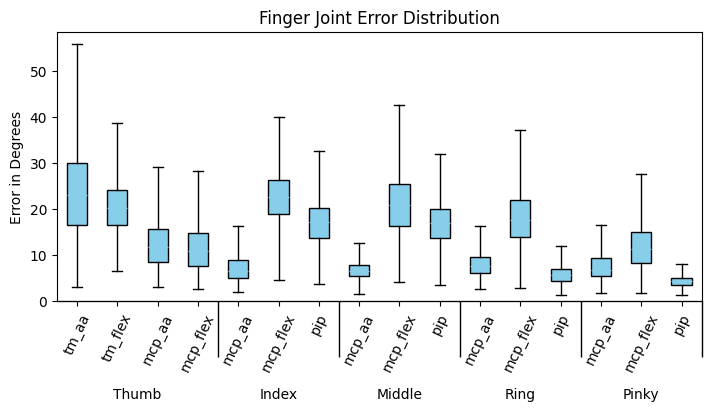

Validation loss: 1002.9349835802625


Epoch 11/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.96it/s, loss=862]


Validation loss: 952.9291599513767


Epoch 12/25: 100%|██████████| 2288/2288 [01:03<00:00, 36.06it/s, loss=914]


Validation loss: 916.5662843930971


Epoch 13/25: 100%|██████████| 2288/2288 [01:03<00:00, 36.02it/s, loss=784]


Validation loss: 877.8269746153504


Epoch 14/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.97it/s, loss=1.15e+3]


Validation loss: 877.7462817638904


Epoch 15/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.49it/s, loss=887]


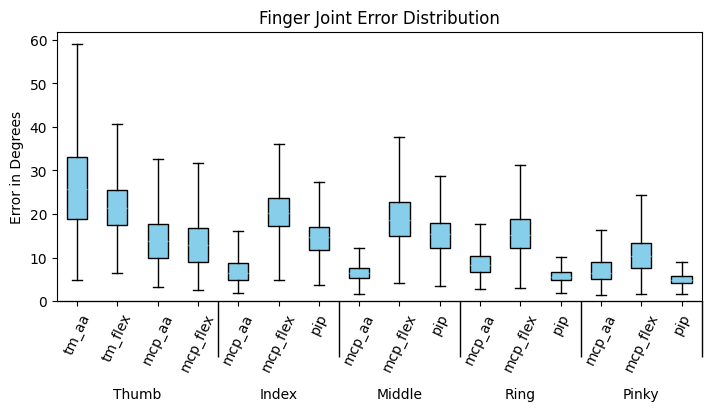

Validation loss: 850.7312041596099


Epoch 16/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.66it/s, loss=1.23e+3]


Validation loss: 852.6226123729786


Epoch 17/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.68it/s, loss=830]


Validation loss: 844.2190719284378


Epoch 18/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.67it/s, loss=874]


Validation loss: 838.2002752344091


Epoch 19/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.66it/s, loss=1.1e+3]


Validation loss: 844.1294784012374


Epoch 20/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.81it/s, loss=861]


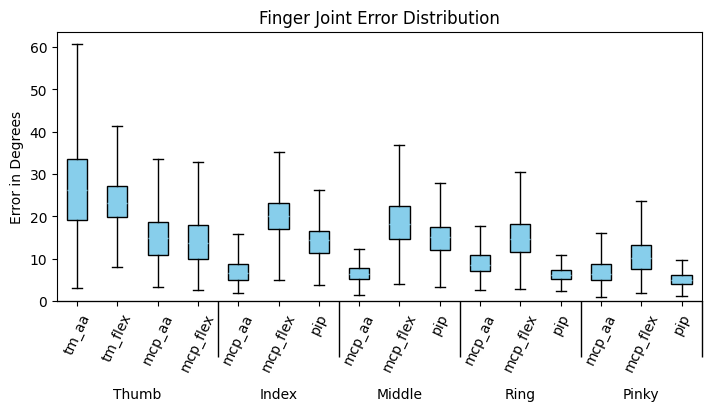

Validation loss: 838.9571994167942


Epoch 21/25: 100%|██████████| 2288/2288 [01:03<00:00, 35.77it/s, loss=1.07e+3]


Validation loss: 839.6893940105305


Epoch 22/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.68it/s, loss=812]


Validation loss: 835.0372981358241


Epoch 23/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.45it/s, loss=938]


Validation loss: 833.1569952264532


Epoch 24/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.63it/s, loss=947]


Validation loss: 835.8303311221249


Epoch 25/25: 100%|██████████| 2288/2288 [01:04<00:00, 35.70it/s, loss=883]


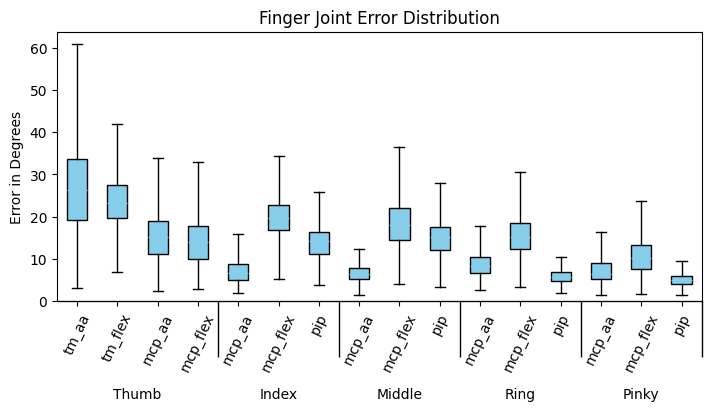

Validation loss: 832.6533124163434


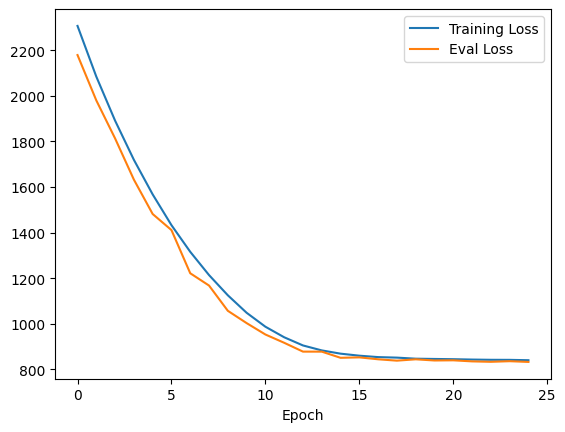

In [28]:
my_cfg = {
    "num_epochs": 25
}
save_path = "/content/saved_model_normed_myo"

trainer = Trainer(my_cfg, model, optimizer, criterion, save_path, device, save_best_worst=True)
training_loss_per_epoch, val_loss_per_epoch = trainer.train(train_loader, test_loader)


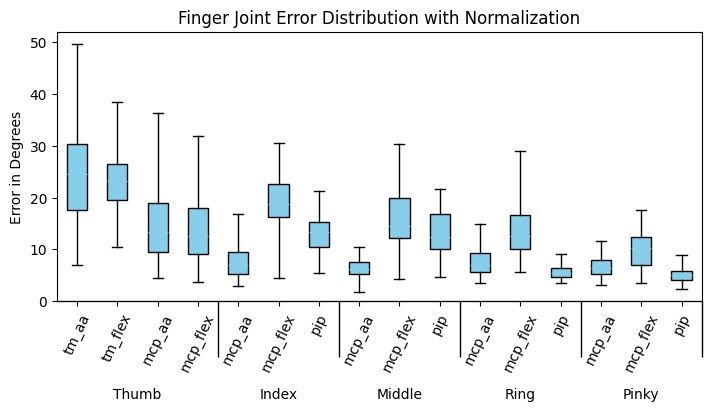

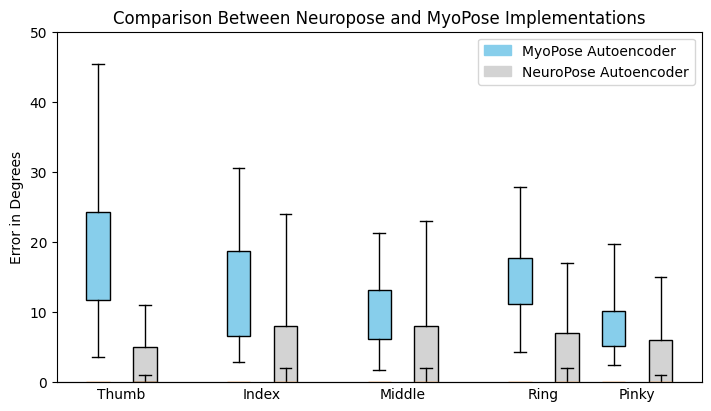

In [29]:
from matplotlib import cbook
from matplotlib import patches as mpatches

angle_errs = np.array(calc_angle_err(trainer.best["logits"], trainer.best["labels"]))
generate_err_boxplot(angle_errs, "Finger Joint Error Distribution with Normalization")

finger_names = ["Thumb", "Index", "Middle", "Ring", "Pinky"]

myo_finger_errs = [
    np.concatenate(angle_errs[:, :4]),
    np.concatenate(angle_errs[:, 4:6]),
    np.concatenate(angle_errs[:, 6:8]),
    np.concatenate(angle_errs[:, 8:10]),
    np.concatenate(angle_errs[:, 10:])
  ]

myo_stats = cbook.boxplot_stats(myo_finger_errs, whis=1.9, labels=['' for _ in myo_finger_errs])
for i in range(5):
  myo_stats[i]['med'] = 0

neuropose_stats = [
    dict(med=0, q1=0, q3=5, whislo=1, whishi=11, fliers=[], label=''),
    dict(med=0, q1=0, q3=8, whislo=2, whishi=24, fliers=[], label=''),
    dict(med=0, q1=0, q3=8, whislo=2, whishi=23, fliers=[], label=''),
    dict(med=0, q1=0, q3=7, whislo=2, whishi=17, fliers=[], label=''),
    dict(med=0, q1=0, q3=6, whislo=1, whishi=15, fliers=[], label=''),
  ]
neuropose_stats = np.array(neuropose_stats)

bxp_stats = []
for i in range(5):
  bxp_stats.append(myo_stats[i])
  bxp_stats.append(neuropose_stats[i])

grouped_positions = [1, 2, 4, 5, 7, 8, 10, 11, 12, 13]

fig, ax = plt.subplots(layout='constrained', figsize=(7, 4))
bplot = ax.bxp(
    bxp_stats,
    positions=grouped_positions,
    showfliers=False,
    manage_ticks=False,
    patch_artist=True)

colors = []
for _ in range(5):
  colors.append("skyblue")
  colors.append("lightgrey")

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title("Comparison Between Neuropose and MyoPose Implementations")
ax.set_ylabel('Error in Degrees')
ax.set_xticks([])

myo_patch = mpatches.Patch(color="skyblue", label="MyoPose Autoencoder")
neuro_patch = mpatches.Patch(color="lightgrey", label="NeuroPose Autoencoder")
ax.legend(handles=[myo_patch, neuro_patch])

plt.ylim(0, 50)

sec = ax.secondary_xaxis(location=0)
sec.set_xticks([1.5, 4.5, 7.5, 10.5, 12.5], labels=[f"{n}" for n in finger_names])
sec.tick_params('x', length=0, width=0)

plt.show()

Epoch 1/25:   0%|          | 0/2288 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(
Epoch 1/25: 100%|██████████| 2288/2288 [00:56<00:00, 40.68it/s, loss=3.22e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2552.1322715065694


Epoch 2/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.77it/s, loss=3.12e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2550.7986290138083


Epoch 3/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.58it/s, loss=2.93e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.8950581583945


Epoch 4/25: 100%|██████████| 2288/2288 [00:54<00:00, 42.29it/s, loss=1.97e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2550.0106058187416


Epoch 5/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.86it/s, loss=2.71e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


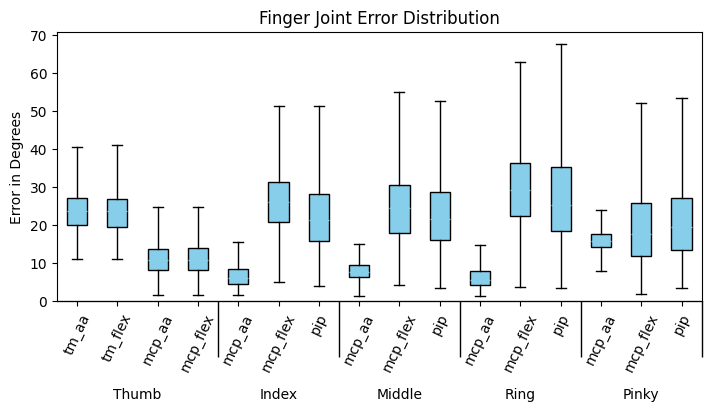

Validation loss: 2550.8605760694386


Epoch 6/25: 100%|██████████| 2288/2288 [00:54<00:00, 42.26it/s, loss=2.62e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2553.4240137913844


Epoch 7/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.72it/s, loss=3.51e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.362913972014


Epoch 8/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.67it/s, loss=3.3e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.587154575161


Epoch 9/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.67it/s, loss=2.2e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2552.4915395883413


Epoch 10/25: 100%|██████████| 2288/2288 [00:52<00:00, 43.36it/s, loss=1.53e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


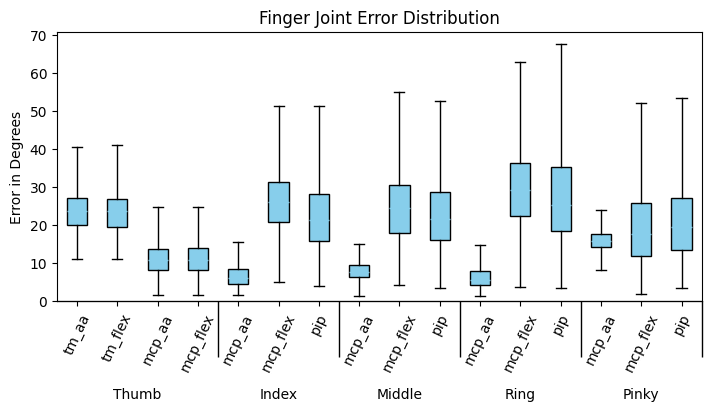

Validation loss: 2550.827459161932


Epoch 11/25: 100%|██████████| 2288/2288 [00:53<00:00, 43.03it/s, loss=2.76e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2550.928003271143


Epoch 12/25: 100%|██████████| 2288/2288 [00:53<00:00, 43.15it/s, loss=2.78e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.8300823931927


Epoch 13/25: 100%|██████████| 2288/2288 [00:52<00:00, 43.36it/s, loss=3.14e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.352117791876


Epoch 14/25: 100%|██████████| 2288/2288 [00:52<00:00, 43.21it/s, loss=1.76e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.413584675822


Epoch 15/25: 100%|██████████| 2288/2288 [00:53<00:00, 43.15it/s, loss=2.25e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


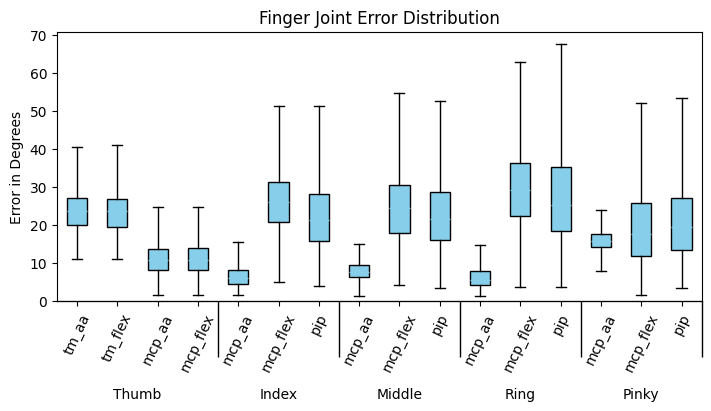

Validation loss: 2551.3756579419114


Epoch 16/25: 100%|██████████| 2288/2288 [00:52<00:00, 43.32it/s, loss=2.07e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.320100157411


Epoch 17/25: 100%|██████████| 2288/2288 [00:52<00:00, 43.40it/s, loss=1.98e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2550.982331175904


Epoch 18/25: 100%|██████████| 2288/2288 [00:53<00:00, 43.12it/s, loss=2.38e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.5238199300697


Epoch 19/25: 100%|██████████| 2288/2288 [00:53<00:00, 43.17it/s, loss=3.25e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2550.5764064121913


Epoch 20/25: 100%|██████████| 2288/2288 [00:52<00:00, 43.28it/s, loss=3.32e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


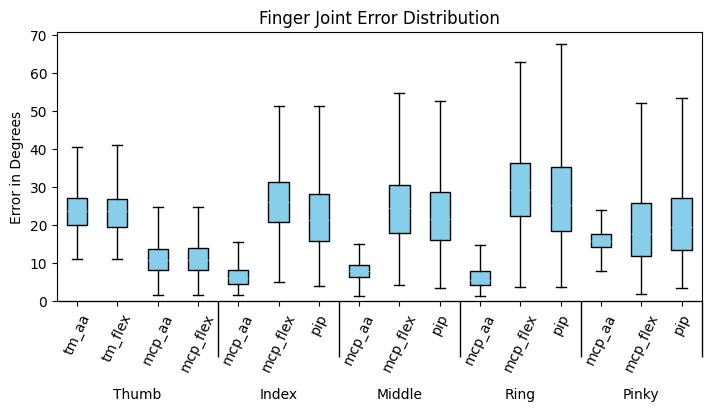

Validation loss: 2552.2900725678132


Epoch 21/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.82it/s, loss=2.34e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2552.492845228502


Epoch 22/25: 100%|██████████| 2288/2288 [00:53<00:00, 43.02it/s, loss=2.09e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2550.807700630668


Epoch 23/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.97it/s, loss=2.03e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.3162376563864


Epoch 24/25: 100%|██████████| 2288/2288 [00:53<00:00, 42.66it/s, loss=2.73e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2551.88744242208


Epoch 25/25: 100%|██████████| 2288/2288 [00:53<00:00, 43.02it/s, loss=3.25e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


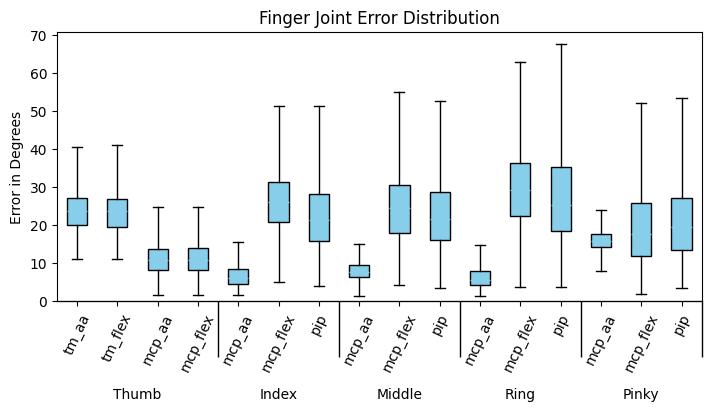

Validation loss: 2551.328079757157


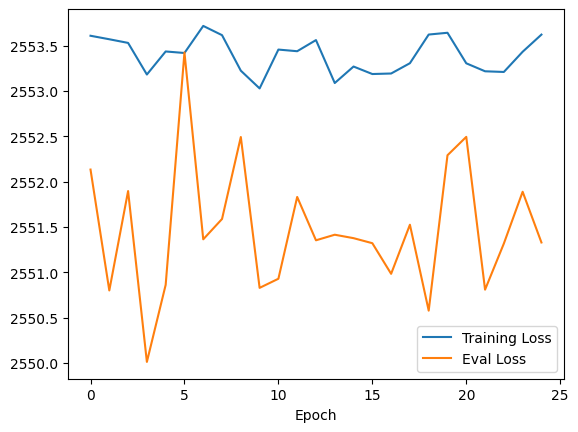

In [26]:
my_cfg = {
    "num_epochs": 25
}
save_path = "/content/MyoPose_Autoencoder_no_const"

model_no_norm = NeuroPoseAutoencoder(leap_thumb_min_max, use_norm=False)

no_normed_trainer = Trainer(my_cfg, model_no_norm, optimizer, criterion, save_path, device, save_best_worst=True)
training_loss_per_epoch, val_loss_per_epoch = no_normed_trainer.train(train_loader, test_loader)

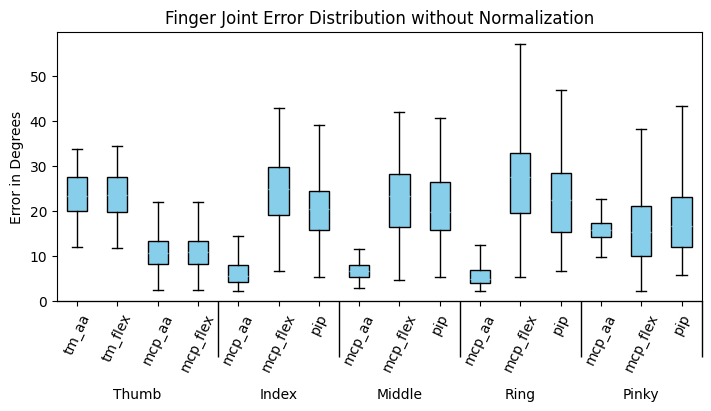

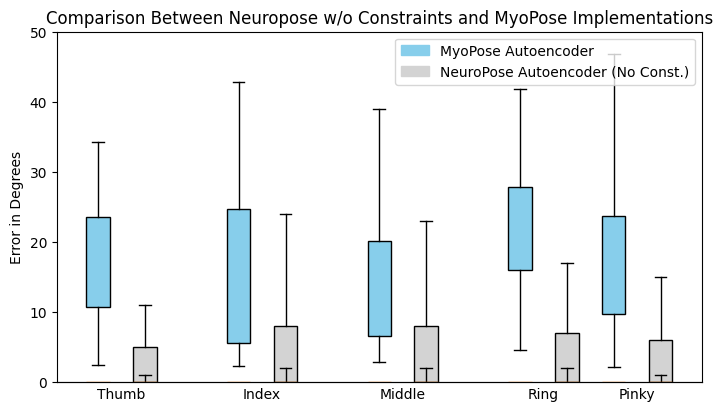

In [27]:
from matplotlib import cbook
from matplotlib import patches as mpatches

angle_errs = np.array(calc_angle_err(no_normed_trainer.best["logits"], no_normed_trainer.best["labels"]))
generate_err_boxplot(angle_errs, "Finger Joint Error Distribution without Normalization")


finger_names = ["Thumb", "Index", "Middle", "Ring", "Pinky"]

myo_finger_errs = [
    np.concatenate(angle_errs[:, :4]),
    np.concatenate(angle_errs[:, 4:6]),
    np.concatenate(angle_errs[:, 6:8]),
    np.concatenate(angle_errs[:, 8:10]),
    np.concatenate(angle_errs[:, 10:])
  ]

myo_stats = cbook.boxplot_stats(myo_finger_errs, whis=1.9, labels=['' for _ in myo_finger_errs])
for i in range(5):
  myo_stats[i]['med'] = 0

neuropose_stats = [
    dict(med=0, q1=0, q3=5, whislo=1, whishi=11, fliers=[], label=''),
    dict(med=0, q1=0, q3=8, whislo=2, whishi=24, fliers=[], label=''),
    dict(med=0, q1=0, q3=8, whislo=2, whishi=23, fliers=[], label=''),
    dict(med=0, q1=0, q3=7, whislo=2, whishi=17, fliers=[], label=''),
    dict(med=0, q1=0, q3=6, whislo=1, whishi=15, fliers=[], label=''),
  ]
neuropose_stats = np.array(neuropose_stats)

bxp_stats = []
for i in range(5):
  bxp_stats.append(myo_stats[i])
  bxp_stats.append(neuropose_stats[i])

grouped_positions = [1, 2, 4, 5, 7, 8, 10, 11, 12, 13]

fig, ax = plt.subplots(layout='constrained', figsize=(7, 4))
bplot = ax.bxp(
    bxp_stats,
    positions=grouped_positions,
    showfliers=False,
    manage_ticks=False,
    patch_artist=True)

colors = []
for _ in range(5):
  colors.append("skyblue")
  colors.append("lightgrey")

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title("Comparison Between Neuropose w/o Constraints and MyoPose Implementations")
ax.set_ylabel('Error in Degrees')
ax.set_xticks([])

myo_patch = mpatches.Patch(color="skyblue", label="MyoPose Autoencoder")
neuro_patch = mpatches.Patch(color="lightgrey", label="NeuroPose Autoencoder (No Const.)")
ax.legend(handles=[myo_patch, neuro_patch])

plt.ylim(0, 50)

sec = ax.secondary_xaxis(location=0)
sec.set_xticks([1.5, 4.5, 7.5, 10.5, 12.5], labels=[f"{n}" for n in finger_names])
sec.tick_params('x', length=0, width=0)

plt.show()

# Evaluate with MyoWare Rectified Data

In [24]:
class MyoCombinedDataset(Dataset):
  def __init__(self, root_dir, num_files, split, split_ratio=0.8, num_samples_per_window=1000, stride=1, transform=None):
    myo_datas = []
    leap_datas = []

    for i in range(num_files):
      # myo_file = f"s{i+1}_bleData.csv"
      myo_file = f"myo8_rect_s{i+1}_bleData.csv"
      # myo_file = f"myo4_env_s{i+1}_bleData.csv"
      myo_file_path = os.path.join(root_dir, myo_file)
      myo_df = pd.read_csv(myo_file_path)
      myo_data = np.asarray(myo_df.iloc[:, 2:])
      myo_datas.append(myo_data)

      # leap_file = f"myo4_env_s{i+1}_leapData.csv"
      leap_file = f"myo8_rect_s{i+1}_leapData.csv"
      # leap_file = f"s{i+1}_leapData.csv"
      leap_file_path = os.path.join(root_dir, leap_file)
      leap_df = pd.read_csv(leap_file_path)
      leap_data = np.asarray(leap_df.iloc[:, 2:])
      leap_datas.append(leap_data)


    myo_data = [build_windows(arr, window_width=1000, stride=stride, normalize=True) for arr in myo_datas]
    self.myo_data = torch.cat(myo_data, dim=0)

    leap_data = [build_windows(arr, window_width=1000, stride=stride) for arr in leap_datas]
    self.leap_data = torch.cat(leap_data, dim=0)

    # TODO: Potentially shuffle data before train-test split? Get rid of
    #   closing finger tracking script artifacts?
    # Combine and shuffle data to remove potential sequential artifacts
    shuffle_indices = torch.randperm(self.myo_data.shape[0])
    self.myo_data = self.myo_data[shuffle_indices]
    self.leap_data = self.leap_data[shuffle_indices]

    assert(self.myo_data.shape[0] == self.leap_data.shape[0])

    self.split = split
    self.num_samples_per_window = num_samples_per_window
    self.transform = transform

    if split == 'train':
      self.myo_data = self.myo_data[:int(split_ratio*len(self.myo_data))]
      self.leap_data = self.leap_data[:int(split_ratio*len(self.leap_data))]
    elif split == 'test':
      self.myo_data = self.myo_data[int(split_ratio*len(self.myo_data)):]
      self.leap_data = self.leap_data[int(split_ratio*len(self.leap_data)):]

    print("Dataset created")
    print(self.myo_data.shape)
    print(self.leap_data.shape)

  def __len__(self):
    return self.myo_data.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    myo_sample = self.myo_data[idx, :].type(torch.float32).unsqueeze(0)
    leap_sample = self.leap_data[idx,:].type(torch.float32).unsqueeze(0)

    if myo_sample.shape[2] == 4:
      padding = torch.zeros((myo_sample.shape[0], myo_sample.shape[1], 4))
      myo_sample = torch.cat((myo_sample, padding), dim=2)

    sample = {'myo': myo_sample, 'leap': leap_sample}

    if self.transform:
      sample = self.transform(sample)

    return sample

  def get_min_max(self, column_index):
    # print(f"min: {self.leap_data[:, :, column_index].min()}, max: {self.leap_data[:, :, column_index].max()}")
    return [self.leap_data[:, :, column_index].min(), self.leap_data[:, :, column_index].max()]

  def get_min_max_leap(self, columns):
    min_max = {}
    for column in columns:
      min_max[column] = self.get_min_max(column)
    return min_max


In [27]:
seed_everything(0)

# Initialize dataset
root_dir = "/content/drive/MyDrive/2 ECEM202A Embedded System/Data/myo8_rect_clean"

num_files=10
rect_train_data = MyoCombinedDataset(
  root_dir=root_dir,
  num_files=num_files,
  split="train",
  stride=1
)

thumb_idxs = [0,1,2,3]
leap_thumb_min_max = rect_train_data.get_min_max_leap(thumb_idxs)
print(f"\nThumb Min Max: {leap_thumb_min_max}\n")

rect_test_data = MyoCombinedDataset(
  root_dir=root_dir,
  num_files=num_files,
  split="test",
  stride=1
)


Dataset created
torch.Size([151160, 1000, 8])
torch.Size([151160, 1000, 16])

Thumb Min Max: {0: [tensor(-53.1530), tensor(45.8940)], 1: [tensor(-47.2410), tensor(53.1530)], 2: [tensor(-28.0870), tensor(55.6160)], 3: [tensor(-22.2720), tensor(55.6160)]}

Dataset created
torch.Size([37791, 1000, 8])
torch.Size([37791, 1000, 16])


Epoch 1/25:   0%|          | 0/2362 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(
Epoch 1/25: 100%|██████████| 2362/2362 [01:13<00:00, 32.29it/s, loss=2.68e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 3086.120988823234


Epoch 2/25: 100%|██████████| 2362/2362 [01:09<00:00, 34.00it/s, loss=2.84e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2828.034662185385


Epoch 3/25: 100%|██████████| 2362/2362 [01:09<00:00, 34.11it/s, loss=2.42e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2591.79830679595


Epoch 4/25: 100%|██████████| 2362/2362 [01:08<00:00, 34.32it/s, loss=2.43e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 2367.4874870700482


Epoch 5/25: 100%|██████████| 2362/2362 [01:08<00:00, 34.33it/s, loss=1.86e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


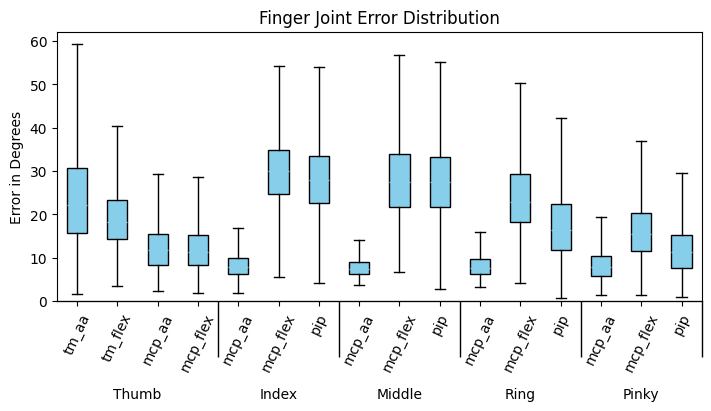

Validation loss: 2157.0081968872278


Epoch 6/25: 100%|██████████| 2362/2362 [01:09<00:00, 34.20it/s, loss=1.97e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1964.9409018579474


Epoch 7/25: 100%|██████████| 2362/2362 [01:08<00:00, 34.33it/s, loss=1.88e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1785.9000934013457


Epoch 8/25: 100%|██████████| 2362/2362 [01:09<00:00, 34.21it/s, loss=1.72e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1633.8375531243391


Epoch 9/25: 100%|██████████| 2362/2362 [01:09<00:00, 34.17it/s, loss=1.54e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1512.953636621259


Epoch 10/25: 100%|██████████| 2362/2362 [01:09<00:00, 34.08it/s, loss=1.41e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


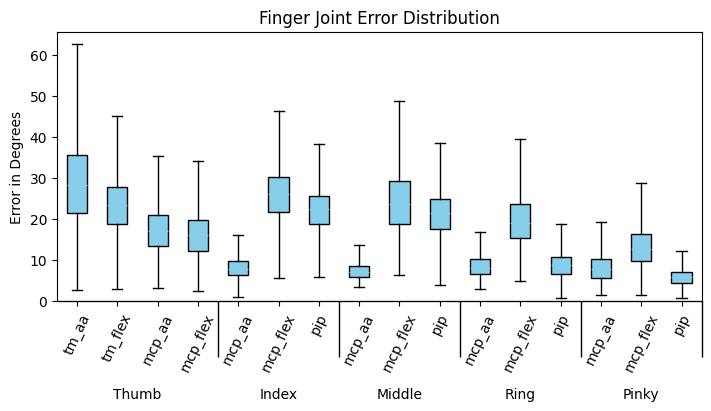

Validation loss: 1417.8588321898794


Epoch 11/25: 100%|██████████| 2362/2362 [01:09<00:00, 33.81it/s, loss=1.16e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1269.9969021818158


Epoch 12/25: 100%|██████████| 2362/2362 [01:09<00:00, 34.04it/s, loss=1.15e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1200.6294151861252


Epoch 13/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.66it/s, loss=1.08e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1127.5611143676965


Epoch 14/25: 100%|██████████| 2362/2362 [01:11<00:00, 33.06it/s, loss=1.07e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1090.873054517304


Epoch 15/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.32it/s, loss=984]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


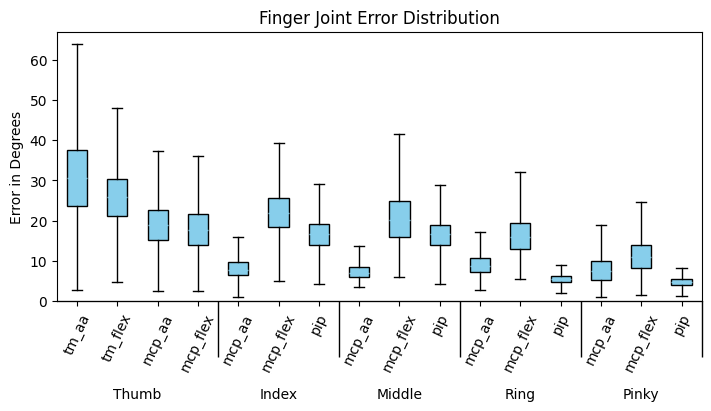

Validation loss: 1055.515568715465


Epoch 16/25: 100%|██████████| 2362/2362 [01:11<00:00, 33.22it/s, loss=1.06e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1032.7042693833612


Epoch 17/25: 100%|██████████| 2362/2362 [01:09<00:00, 33.76it/s, loss=958]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1006.028171184301


Epoch 18/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.67it/s, loss=941]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1001.2560453721513


Epoch 19/25: 100%|██████████| 2362/2362 [01:09<00:00, 33.78it/s, loss=1.1e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1004.5070989773358


Epoch 20/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.68it/s, loss=1.03e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


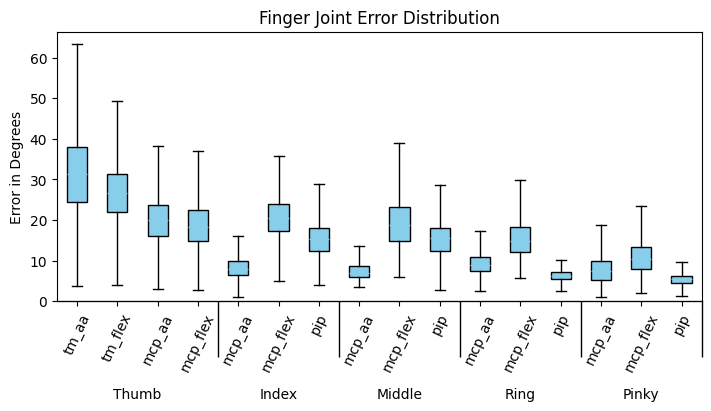

Validation loss: 997.3976081034859


Epoch 21/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.72it/s, loss=931]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 993.691028369058


Epoch 22/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.45it/s, loss=959]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 992.5173852084655


Epoch 23/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.30it/s, loss=932]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 989.7762427418769


Epoch 24/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.38it/s, loss=932]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 989.6607523496986


Epoch 25/25: 100%|██████████| 2362/2362 [01:10<00:00, 33.57it/s, loss=1.05e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


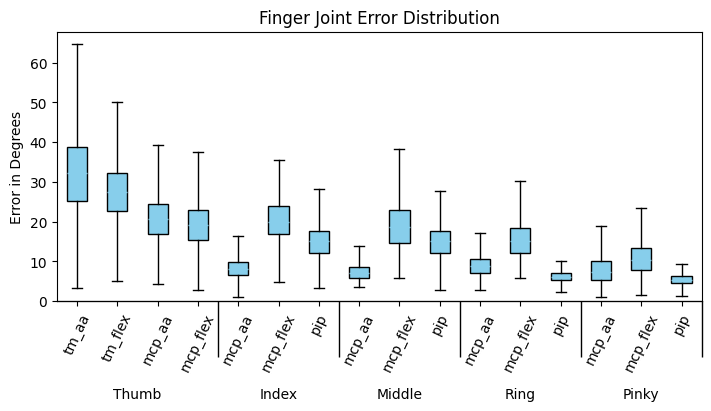

Validation loss: 993.498750173501


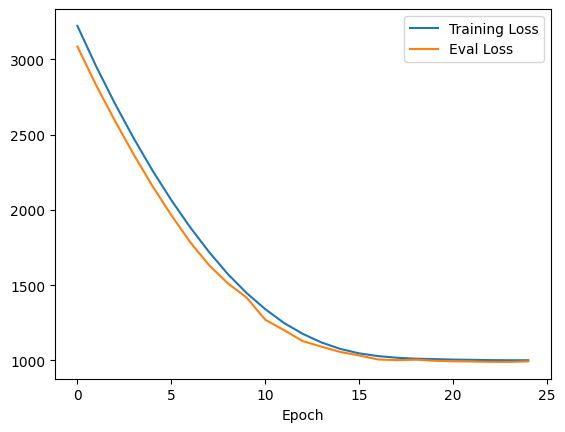

In [30]:
model = NeuroPoseAutoencoder(leap_thumb_min_max)

# Define the Optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,
    amsgrad=False
)


# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
rect_train_loader = torch.utils.data.DataLoader(
    rect_train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
rect_test_loader = torch.utils.data.DataLoader(
    rect_test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Set the Loss Function
# criterion = nn.MSELoss()
criterion = NeuroPoseLoss()


my_cfg = {
    "num_epochs": 25
}
save_path = "/content/MyoPose_Rect_Model_Normed"

trainer = Trainer(my_cfg, model, optimizer, criterion, save_path, device, save_best_worst=True)
training_loss_per_epoch, val_loss_per_epoch = trainer.train(rect_train_loader, rect_test_loader)


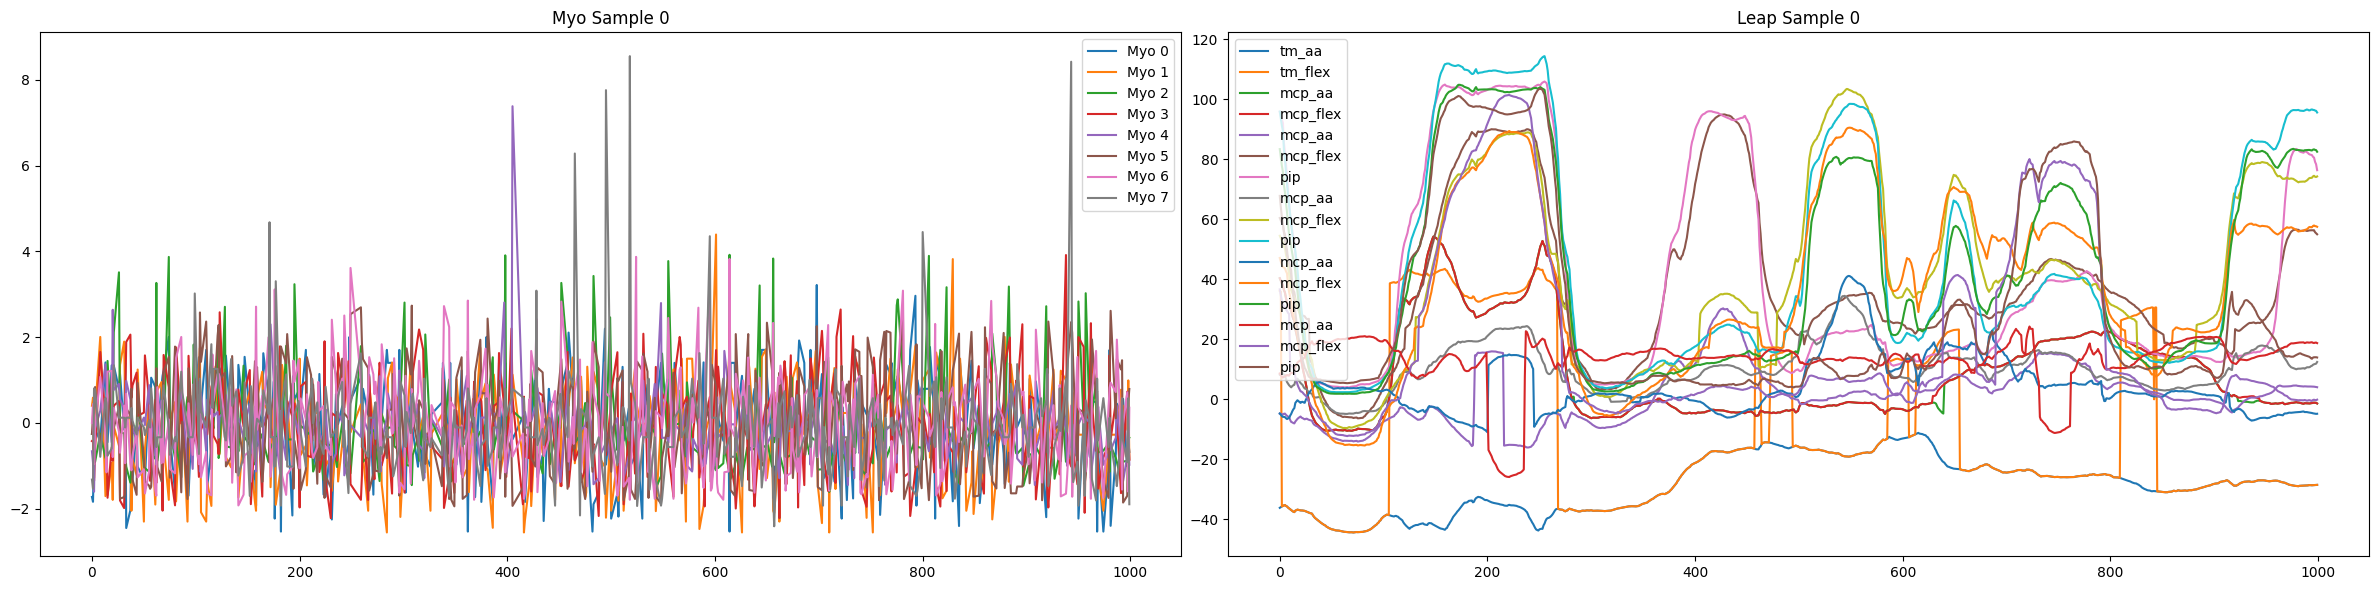

In [38]:
worst_sample = {"myo": trainer.worst["input"][0].cpu(), "leap": trainer.worst["labels"][0].cpu()}

plot_sample(worst_sample, 0)

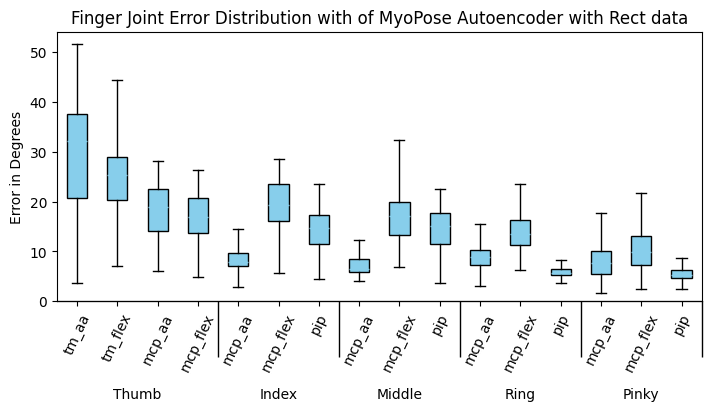

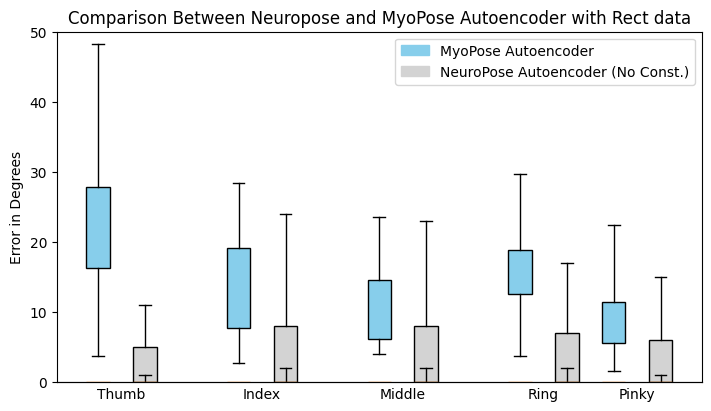

In [42]:
from matplotlib import cbook
from matplotlib import patches as mpatches

angle_errs = np.array(calc_angle_err(trainer.best["logits"], trainer.best["labels"]))
title = "MyoPose Autoencoder with Rect data"

generate_err_boxplot(angle_errs, f"Finger Joint Error Distribution with of {title}")


finger_names = ["Thumb", "Index", "Middle", "Ring", "Pinky"]

myo_finger_errs = [
    np.concatenate(angle_errs[:, :4]),
    np.concatenate(angle_errs[:, 4:6]),
    np.concatenate(angle_errs[:, 6:8]),
    np.concatenate(angle_errs[:, 8:10]),
    np.concatenate(angle_errs[:, 10:])
  ]

myo_stats = cbook.boxplot_stats(myo_finger_errs, whis=1.9, labels=['' for _ in myo_finger_errs])
for i in range(5):
  myo_stats[i]['med'] = 0

neuropose_stats = [
    dict(med=0, q1=0, q3=5, whislo=1, whishi=11, fliers=[], label=''),
    dict(med=0, q1=0, q3=8, whislo=2, whishi=24, fliers=[], label=''),
    dict(med=0, q1=0, q3=8, whislo=2, whishi=23, fliers=[], label=''),
    dict(med=0, q1=0, q3=7, whislo=2, whishi=17, fliers=[], label=''),
    dict(med=0, q1=0, q3=6, whislo=1, whishi=15, fliers=[], label=''),
  ]
neuropose_stats = np.array(neuropose_stats)

bxp_stats = []
for i in range(5):
  bxp_stats.append(myo_stats[i])
  bxp_stats.append(neuropose_stats[i])

grouped_positions = [1, 2, 4, 5, 7, 8, 10, 11, 12, 13]

fig, ax = plt.subplots(layout='constrained', figsize=(7, 4))
bplot = ax.bxp(
    bxp_stats,
    positions=grouped_positions,
    showfliers=False,
    manage_ticks=False,
    patch_artist=True)

colors = []
for _ in range(5):
  colors.append("skyblue")
  colors.append("lightgrey")

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title(f"Comparison Between Neuropose and {title}")
ax.set_ylabel('Error in Degrees')
ax.set_xticks([])

myo_patch = mpatches.Patch(color="skyblue", label="MyoPose Autoencoder (Rect Data)")
neuro_patch = mpatches.Patch(color="lightgrey", label="NeuroPose Autoencoder (No Const.)")
ax.legend(handles=[myo_patch, neuro_patch])

plt.ylim(0, 50)

sec = ax.secondary_xaxis(location=0)
sec.set_xticks([1.5, 4.5, 7.5, 10.5, 12.5], labels=[f"{n}" for n in finger_names])
sec.tick_params('x', length=0, width=0)

plt.show()



# TODO

## Autoencoder

### Must Do
- ~Normalize myo data~
- ~Save best performing weights~
- ~Compare myo8_env to myo8_rect~
  - Collect more of the better performing data
    - Improve dataset generation
  - Collect from other people
- Ablation study w/ and w/o constraint norm layer and custom loss function
- ~Write prettier boxplotting~

### Should Do
- ~Add config instead of hard-coding hyperparameters~
- ~Improve training and evaluation scripts~

## Transformer-Based

### Must Do
- ~Migrate data stuffs~
- ~**Figure out GPU Memory issue**~
- Train on results
- Try sinusoidal positional *encoding*
- ~Diagram of model~
-

### Should Do
- Way to visualize attention
- See what index of the window to use as a label (eg. middle or beginning or end)
-
